In [1]:
# Import Python library for working with dataframes
import pandas as pd

# Import Dataset and DatasetDict classes from the datasets library that helps us prepare our own dataset for use in training and evaulating machine learning models
from datasets import Dataset, DatasetDict

# Import Python library that helps us extract certain target patterns from strings with regular expressions
import re

# Setting a seed helps us replicate results across multiple runs
SEED = 42

In [3]:
# Load the csv file
df = pd.read_csv('../data/ELLIPSE_Final_github.csv')

# Allows us to take a quick look at the first two rows of the loaded dataframe
df.head(2)

,text_id_kaggle,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,task,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions
0,5AA45740A848,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Male,8,Hispanic/Latino,111,122,118,7,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,3.5,2.5,3.5,3.0,3.5,2.5
1,790891A35047,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Female,8,Hispanic/Latino,99,105,102,6,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,4.0,3.5,3.0,3.5


## Clean text

Collapse all contiguous spans of whitespace into a single space. Also removes leading and trailing whitespace.

Specific preprocessing steps are a matter of preference. Most transformers (especially newer, larger ones) were pretrained on diverse and messy text scraped from the internet.

In [11]:
# Remove all leading and trailing whitespace using strip()
# Find all contiguous spans of whitespace using regex patterns (denoted by \s+), and replace them with a single space
df['clean_text'] = df.full_text.apply(lambda text: re.sub(r'\s+', r' ', text.strip()))

# Print 5 example texts after cleaning
df.clean_text.sample(5)

879     "Success consists of going from failure to fai...
4592    Should students graduate from High School earl...
2272    Behavior the best way to influence other peopl...
5080    Do you think students would benefit from being...
5814    I think that the curfew is good idea for adopt...
Name: clean_text, dtype: object

## We have some long texts

Most transformers have a maximum sequence length of 512 tokens. Transformer tokenizers do not operate at the word level. Many words will be split into "sub-word tokens" (for example, the word "transformer" will be split into "transform" and "##er" and will be treated as two separate tokens). This means a typical transformer can handle roughly ~400 words.

For this showcase, we will simply truncate texts that are too long, but there are models that can handle longer sequence lengths (e.g., Longformer). There are also approaches for handling longer sequences with standard pretrained models, such as using a "sliding window" approach. We truncate in the interest of simplicity.

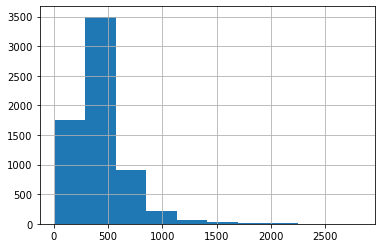

In [15]:
# Create histogram showing the number of words in the ELLIPSE texts
df.num_words.hist();

### Truncation

To see how many texts will be truncated and what will be lost, we need to use the transformer's tokenization scheme.

We will be developing models from `bert-base-uncased`, so we need to import its `sentencepiece` tokenizer. This will produce a warning, since we set `truncation=False` (which is the default value).

In [27]:
# Import tokenizer from the transformer library which will help us transform texts into separate tokens with embeddings.
from transformers import AutoTokenizer

# Initialize tokenizer using a pre-trained transformer model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create function that will take a text as an input, tokenize it, and returns specific ids for each individual token.
def tokenize(text):
    input_ids = tokenizer(text, truncation=False)['input_ids']
    return input_ids

# Apply the function to the clean text (= text with collapsed whitespaces)
input_ids = df.clean_text.apply(tokenize)

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


The following functions count the number of tokens in each sample.

Around 40% of our samples will be truncated. When we evaluate our model, we will report how this affects performance.

In [37]:
# Import library that helps us work with arrays
import numpy as np

# Print out descriptive statistics about the number of tokens in each text
input_ids.str.len().describe(percentiles=np.arange(.5, .8, step=.05))

count    6482.000000
mean      489.050139
std       216.793364
min        16.000000
50%       457.000000
55%       480.000000
60%       506.000000
65%       531.000000
70%       564.000000
75%       599.000000
80%       637.000000
max      1527.000000
Name: clean_text, dtype: float64

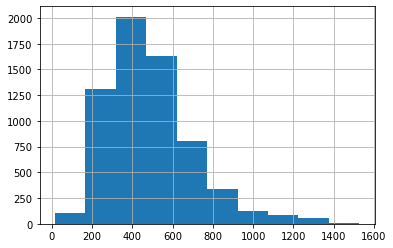

In [41]:
# Display histogram showing the number of tokens in each text
input_ids.str.len().hist();

## Build Dataset

Create a DatasetDict that will hold the dataset partitions. Saving this to disk promotes reproducibility by guaranteeing that different scripts are accessing the same data splits. I find that it also helps to organize our research code.

It is possible to tokenize at this stage, but I prefer to tokenize at the last minute. This affords us the flexibility of changing tokenization schemes, which could be useful if we want to test different pretrained models (that may use different tokenizers).

In [16]:
# This function will take in a dataframe and return a DatasetDict object
def build_dataset(df):
    
    # Create list of columns that we are interested in working with
    columns = ['text_id',
               'clean_text',
               'Overall',
               'Cohesion',
               'Syntax',
               'Vocabulary',
               'Phraseology',
               'Grammar',
               'Conventions']
    
    # Use the above list to only select the datapoints in the columns we are interested in. 
    # We are also renaming the column 'clean_text' into 'text' since this is the only 'text' data we will be working with anyway.
    df = df[columns].rename(columns = {'clean_text': 'text'})
    
    # Use the Dataset class method to transform a dataframe into a Dataset object.
    ds = Dataset.from_pandas(df, preserve_index=False)
    
    # Split data into train, development, and test sets.
    # 70% train, 15% development, 15% test
    # Use the SEED we defined in the first cell to ensure reproducibility of the split.
    train_remains = ds.train_test_split(test_size=0.3, seed=SEED)
    train = train_remains['train']
    _remains = train_remains['test']
    
    dev_test = _remains.train_test_split(test_size=0.5, seed=SEED)
    dev = dev_test['train']
    test = dev_test['test']
    
    # Initialize DatasetDict object using the train, dev, and test sets we defined above.
    dd = DatasetDict({
        'train': train,
        'dev': dev, 
        'test': test})

    return dd

In [17]:
dd = build_dataset(df)

In [ ]:
# Save the DatasetDict object. We will be using it in the next notebooks.
dd.save_to_disk('../data/ellipse.hf')